In [37]:
import os
import numpy as np
import pandas as pd        
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain

import torch
import torch.nn.functional as F
import torch_geometric
from torch import Tensor
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data 
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind

print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)

Torch version: 2.8.0+cpu
Torch Geometric version: 2.6.1


In [38]:
RANDOM_STATE = 42
NUM_EPOCHS = 100
def set_seed_for_torch(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)      # For single-GPU.
        torch.cuda.manual_seed_all(seed)  # For multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def set_seed_for_numpy(seed):
    np.random.seed(seed) 
    
def set_seed_for_random(seed):
    random.seed(seed)  
set_seed_for_torch(RANDOM_STATE)
set_seed_for_numpy(RANDOM_STATE)
set_seed_for_random(RANDOM_STATE)

In [39]:
elliptic_txs_features = pd.read_csv('elliptic_txs_features.csv', header=None)
elliptic_txs_classes = pd.read_csv('elliptic_txs_classes.csv')
elliptic_txs_edgelist = pd.read_csv('elliptic_txs_edgelist.csv')

elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]

print(f"""Shapes
{4*' '}Features : {elliptic_txs_features.shape[0]:8,} (rows)  {elliptic_txs_features.shape[1]:4,} (cols)
{4*' '}Classes  : {elliptic_txs_classes.shape[0]:8,} (rows)  {elliptic_txs_classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {elliptic_txs_edgelist.shape[0]:8,} (rows)  {elliptic_txs_edgelist.shape[1]:4,} (cols)
""")

Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



In [40]:
elliptic_txs_features.head(3)

,txId,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792


In [41]:
elliptic_txs_classes.head(3) 

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown


In [42]:
elliptic_txs_edgelist.head(3)

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870


In [43]:
# 将类别标签从数字编码转换为可读的文字标签
# '1' 表示非法交易(illicit), '2' 表示合法交易(licit)
elliptic_txs_classes['class_mapped'] = elliptic_txs_classes['class'].replace({'1': 'illicit', '2': 'licit'})

# 计算各类别的百分比分布（保留两位小数）
percentage_distribution = round(100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True), 2)
# 计算各类别的数量统计
class_counts = elliptic_txs_classes['class_mapped'].value_counts()

# 定义类别到表情符号的映射关系
emoji_mapping = {'licit': '✅', 'illicit': '❌', 'unknown': '🤷'}
# 为每个类别添加对应的表情符号列
elliptic_txs_classes['emoji'] = elliptic_txs_classes['class_mapped'].map(emoji_mapping)

# 创建一个汇总DataFrame，包含类别映射、原始类别、计数、百分比和表情符号
classes_df = pd.DataFrame({
    'Class Mapped': elliptic_txs_classes['class_mapped'].unique(),
    'Class Raw': elliptic_txs_classes['class'].unique(),    
    'Counts': class_counts.to_numpy(),
    'Percentage': percentage_distribution.to_numpy(),
    'Emoji': [emoji_mapping[class_label] for class_label in elliptic_txs_classes['class_mapped'].unique()]
})
classes_df

,Class Mapped,Class Raw,Counts,Percentage,Emoji
0,unknown,unknown,157205,77.15,🤷
1,licit,2,42019,20.62,✅
2,illicit,1,4545,2.23,❌


In [44]:
num_nodes = elliptic_txs_features.shape[0]
num_edges = elliptic_txs_edgelist.shape[0]

print(f"nodes节点数量: {num_nodes:,}")
print(f"edges边的数量: {num_edges:,}")

nodes节点数量: 203,769
edges边的数量: 234,355


简单分析

In [45]:
G = nx.from_pandas_edgelist(elliptic_txs_edgelist, 'txId1', 'txId2')

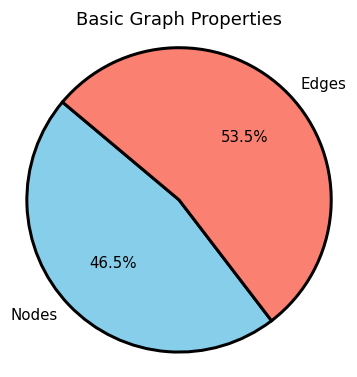

In [46]:
## 图整体的情况，边和节点数量
# 创建一个新的图形窗口，设置图形大小为4x4英寸，分辨率为108 DPI
plt.figure(figsize=(4, 4),dpi=108)
# 定义饼图的数据：节点数量和边的数量
sizes = [num_nodes, num_edges]
# 定义饼图的标签
labels = ['Nodes', 'Edges']
# 定义饼图的颜色：节点用天蓝色，边用三文鱼色
colors = ['skyblue', 'salmon']
# 绘制饼图，设置自动显示百分比，起始角度140度
# 设置扇形边缘为黑色，线宽2，启用抗锯齿
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, 
        wedgeprops = {'edgecolor' : 'black', 
                      'linewidth': 2, 
                      'antialiased': True})
# 设置图表标题
plt.title('Basic Graph Properties')
# 设置坐标轴相等，使饼图呈圆形而非椭圆形
plt.axis('equal')
# 显示图表
plt.show()

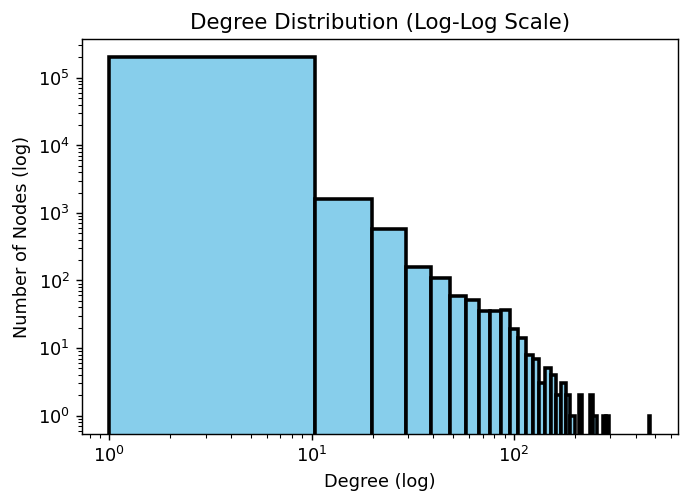

In [47]:
# ---度的分布，由于肯定是一个右偏分布，所以用对数轴---
plt.figure(figsize=(6, 4),dpi=128)
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black', linewidth=2.0)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (log)')
plt.ylabel('Number of Nodes (log)')
plt.show()

大部分的度都在0和1附近，也就是孤立的节点，少数有100个及以上的节点，这肯定就是团伙了。

基础统计

In [48]:
# 简单采样分析------分层采样------这是一个常见的数据预处理步骤，特别是在处理大型图数据集时。
classes_sampled = elliptic_txs_classes.groupby('class_mapped').sample(frac=0.05, random_state=RANDOM_STATE)
txIds_sampled = classes_sampled['txId']

# 根据采样的 txIds 过滤 elliptic_txs_edgelist
edgelist_sampled = elliptic_txs_edgelist[
    elliptic_txs_edgelist['txId1'].isin(txIds_sampled) | elliptic_txs_edgelist['txId2'].isin(txIds_sampled)
]

# 根据采样的 txIds 过滤 elliptic_txs_features  
features_sampled = elliptic_txs_features[elliptic_txs_features['txId'].isin(txIds_sampled)]

print(f"Sampled Classes:\n{classes_sampled['class_mapped'].value_counts()}\n")
print(f"Sampled Edgelist: {edgelist_sampled.shape[0]:,}")
print(f"Sampled Features: {features_sampled.shape[0]:,}")

# 原始数据20w，太大了，我们取了5%的数据，大概1w条，最后样本里面的合法交易的2.1k，未定义的7.8k，不合法的是227条。

Sampled Classes:
class_mapped
unknown    7860
licit      2101
illicit     227
Name: count, dtype: int64

Sampled Edgelist: 23,051
Sampled Features: 10,188


In [49]:
num_nodes = features_sampled.shape[0]
num_edges = edgelist_sampled.shape[0]

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")

Number of nodes: 10,188
Number of edges: 23,051


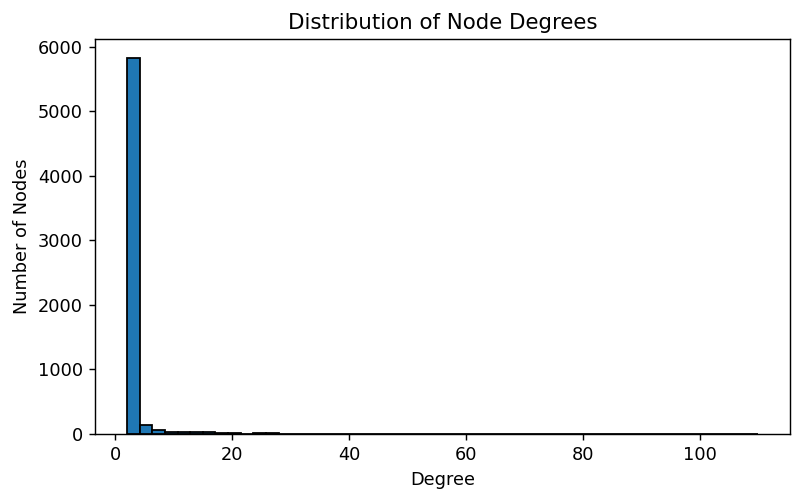

In [50]:
plt.figure(figsize=(7, 4),dpi=128)

node_degrees = edgelist_sampled['txId1'].value_counts() + edgelist_sampled['txId2'].value_counts()
node_degrees.hist(bins=50, edgecolor='black')
plt.title('Distribution of Node Degrees')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.grid(False)
plt.show()

In [51]:
# 构图
G = nx.from_pandas_edgelist(edgelist_sampled, 'txId1', 'txId2')
# --- 连接组件，极大连通子图 ---
num_connected_components = nx.number_connected_components(G) #联通分量的数量
print(f"Number of connected components: {num_connected_components}")

# --- 最大的连接，最大的连通子图  ---
giant_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant_component)

print(f"Giant component - Number of nodes: {G_giant.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_giant.number_of_edges():,}")

Number of connected components: 7297
Giant component - Number of nodes: 400
Giant component - Number of edges: 431


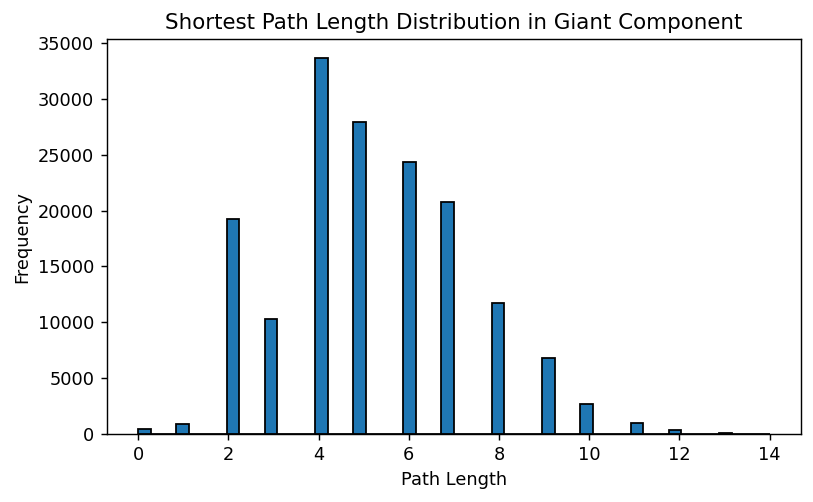

In [52]:
# 最大团伙里面的最短路径长度分布 #
path_lengths = dict(nx.shortest_path_length(G_giant))
path_lengths_values = [length for target_lengths in path_lengths.values() for length in target_lengths.values()]

plt.figure(figsize=(7, 4),dpi=128)
plt.hist(path_lengths_values, bins=50, edgecolor='black')
plt.title('Shortest Path Length Distribution in Giant Component')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.show()

一个节点需要通过几条边才能找到另外一个节点，就是路径长度，上面的图是这个最大的团伙里面的最小路径长度的分布， 可以看到基本上再4和5附近，也就是说一个交易一般通过最多4-5个交易就能关联上



节点中心性度量

1. 度中心性 (Degree Centrality)
定义：节点的直接连接数量
公式：度中心性 = 节点的度数 / (总节点数 - 1)
计算：统计该节点有多少条边
含义：连接数越多，通常越重要
示例：在交易网络中，连接多的节点可能是重要的中转节点

解释: 具有高度中心性的节点是高度连接的，并且通过与许多其他节点直接交互，可能在网络中发挥关键作用。 简而言之，团伙头目，团伙里面认识最多的人。

2. 中介中心性 (Betweenness Centrality)
定义：节点作为“桥梁”的频率
公式：介数中心性 = 经过该节点的最短路径数 / 所有最短路径数
计算：
找出所有节点对之间的最短路径
统计有多少条最短路径经过该节点
除以总的路径数
含义：控制信息流的关键节点，移除后可能断开很多连接
示例：移除该节点后，很多节点之间的路径会变长或断开

解释: 具有高中介中心性的节点对网络中的信息或资源流具有重要控制权，因为它连接网络的不同部分。它通常表示对通信至关重要的节点。 简而言之，团伙联系人，团伙里面的人和组织都是通过他来进行联系控制的。



3. 接近中心性 (Closeness Centrality)
定义：节点到其他所有节点的平均距离
公式：接近中心性 = (节点总数 - 1) / 到所有其他节点的最短距离之和
计算：
计算该节点到图中其他所有节点的最短距离
求和后取倒数
含义：平均距离越短，越能快速到达其他节点
示例：在社交网络中，接近中心性高的节点能更快传播信息

解释: 具有高接近中心性的节点可以与所有其他节点快速交互，并且可以成为信息或影响整个网络的有效传播者。 简而言之，团伙情报员，团伙里面的人都是通过他来进行最短的联系的。

In [53]:
degree_centrality = nx.degree_centrality(G_giant)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_degree_centrality = pd.DataFrame(top_degree_centrality, columns=['Node', 'Degree Centrality'])

print("Top 10 nodes by degree centrality:")
print("==================================")
print(df_top_degree_centrality)

Top 10 nodes by degree centrality:
        Node  Degree Centrality
0   22837965           0.275689
1   22837835           0.192982
2  279199578           0.030075
3    3807285           0.027569
4  279187194           0.027569
5   22837973           0.022556
6   90716926           0.022556
7    8128388           0.022556
8   22837808           0.020050
9   22838007           0.020050


22837965 ,22837835，这两个交易关联了特别多别的交易

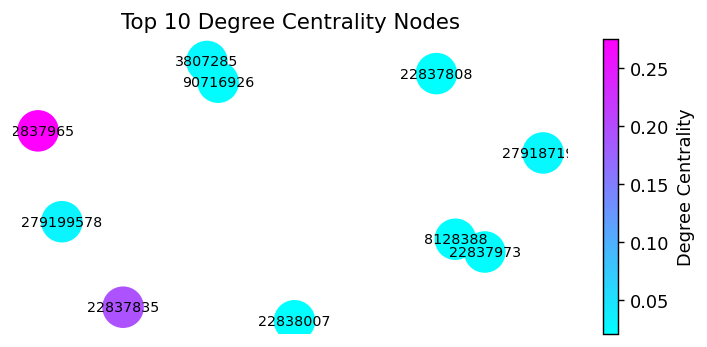

In [54]:
# 从前10个度中心性节点的DataFrame中提取节点列表
# 注意：前10个节点的选择是在Cell 27中通过 [:10] 切片操作完成的
top_nodes_by_ = df_top_degree_centrality['Node'].tolist()

# 从最大连通子图中提取这前10个节点构成的子图
# 注意：度中心性高的节点虽然连接数多，但它们之间可能没有直接连接
#       因为它们可能各自连接到不同的节点群组，所以子图中可能看不到连接线
subgraph = G_giant.subgraph(top_nodes_by_)

node_color = [degree_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

plt.figure(figsize=(7, 3), dpi=128)
ax = plt.gca()  # 获取当前坐标轴对象
sc = nx.draw(subgraph, with_labels=True, node_size=500, edge_color='gray', font_size=8,
             node_color=node_color_normalized, cmap=cmap, ax=ax)
plt.title('Top 10 Degree Centrality Nodes')
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Degree Centrality')
plt.show()

In [55]:
# Betweenness centrality. 中介中心性
betweenness_centrality = nx.betweenness_centrality(G_giant)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

print("Top 10 nodes by betweenness centrality:")
print("=======================================")
print(df_top_betweenness_centrality)

Top 10 nodes by betweenness centrality:
        Node  Betweenness Centrality
0   22837835                0.553959
1   22837965                0.491607
2   90716926                0.166458
3   22837784                0.165590
4  279187194                0.164591
5    3807285                0.144993
6    3097782                0.113509
7    8128388                0.103709
8    1435388                0.092219
9   21296808                0.086872


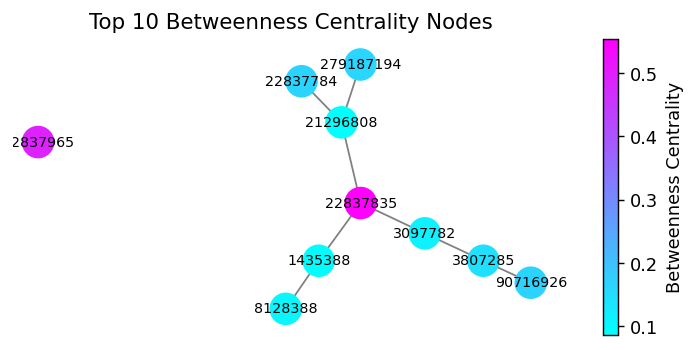

In [56]:
# 从前10个中介中心性节点的DataFrame中提取节点列表
# 注意：前10个节点的选择是在Cell 30中通过 [:10] 切片操作完成的
top_nodes_by_ = df_top_betweenness_centrality['Node'].tolist()
# 注意：中介中心性高的节点通常作为"桥梁"连接网络的不同部分，
#       因此这些节点之间更可能有直接连接，导致子图中会出现连接线
subgraph = G_giant.subgraph(top_nodes_by_)

# 为子图中的每个节点获取其中介中心性值，用于后续的颜色映射
node_color = [betweenness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

fig, ax = plt.subplots(figsize=(7, 3), dpi=128)
nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8, 
        node_color=node_color_normalized, cmap=cmap, ax=ax)
plt.title('Top 10 Betweenness Centrality Nodes')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Betweenness Centrality')
plt.show()

In [57]:
# Closeness centrality. 接近中心性
closeness_centrality = nx.closeness_centrality(G_giant)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_closeness_centrality = pd.DataFrame(top_closeness_centrality, columns=['Node', 'Closeness Centrality'])

print("Top 10 nodes by closeness centrality:")
print("=====================================")
print(df_top_closeness_centrality)

Top 10 nodes by closeness centrality:
        Node  Closeness Centrality
0   22837835              0.317928
1   22837965              0.293814
2    2203811              0.290605
3    1805107              0.285817
4   11447640              0.285817
5    2205152              0.285817
6    1367537              0.285817
7    1437191              0.285817
8   21296808              0.274038
9  279187194              0.271613


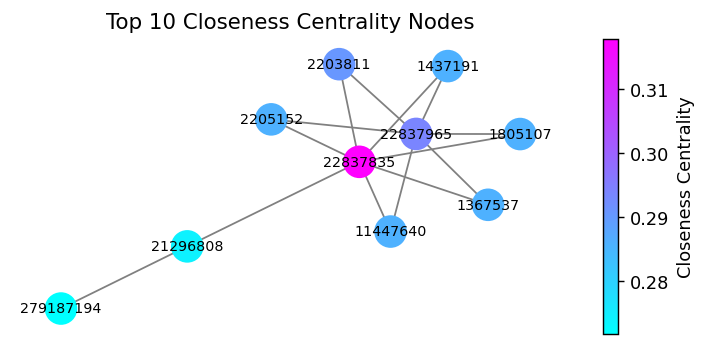

In [58]:
top_nodes_by_closeness = df_top_closeness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_closeness)
node_color = [closeness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# Plotting #
# -------- #
fig, ax = plt.subplots(figsize=(7, 3), dpi=128)

nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8, 
        node_color=node_color_normalized, cmap=cmap, ax=ax)
plt.title('Top 10 Closeness Centrality Nodes')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax, label='Closeness Centrality')
plt.show()

对采样出来的图进行可视化

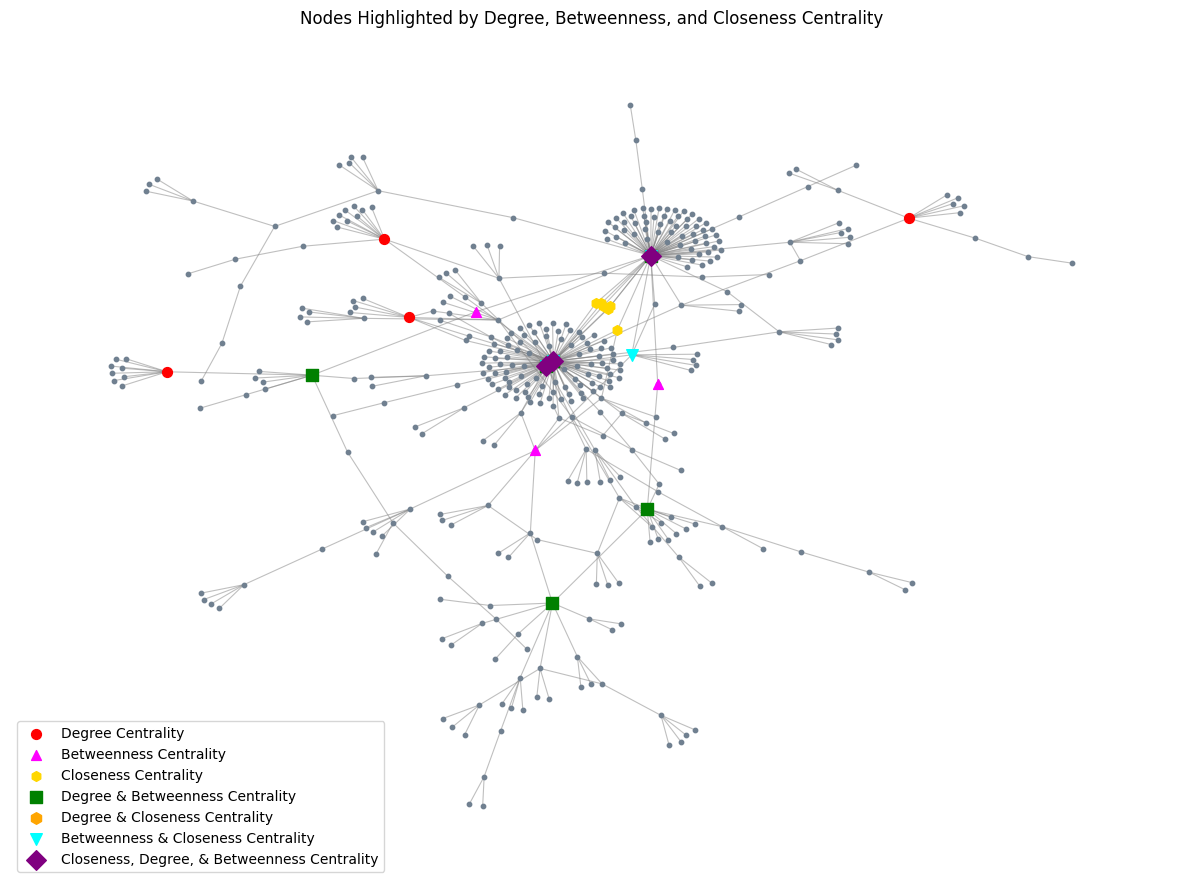

In [59]:
# --------- #
# Preparing #

# 识别在每种中心度量中排名靠前的节点及其组合
top_nodes_degree = set([node for node, _ in top_degree_centrality])
top_nodes_betweenness = set([node for node, _ in top_betweenness_centrality])
top_nodes_closeness = set([node for node, _ in top_closeness_centrality])

top_nodes_both = top_nodes_degree.intersection(top_nodes_betweenness)
top_nodes_closeness_and_degree = top_nodes_closeness.intersection(top_nodes_degree)
top_nodes_closeness_and_betweenness = top_nodes_closeness.intersection(top_nodes_betweenness)
top_nodes_all_three = top_nodes_closeness.intersection(top_nodes_degree).intersection(top_nodes_betweenness)

# 根据中心度量分配颜色和形状。
node_color = []  ;  node_shape = []

for node in G_giant.nodes():
    if node in top_nodes_all_three:
        node_color.append('purple')
        node_shape.append('D')
    elif node in top_nodes_closeness_and_degree:
        node_color.append('orange')
        node_shape.append('h')
    elif node in top_nodes_closeness_and_betweenness:
        node_color.append('cyan')
        node_shape.append('v')
    elif node in top_nodes_both:
        node_color.append('green')
        node_shape.append('s')
    elif node in top_nodes_degree:
        node_color.append('red')
        node_shape.append('o')
    elif node in top_nodes_betweenness:
        node_color.append('magenta')
        node_shape.append('^')
    elif node in top_nodes_closeness:
        node_color.append('yellow')
        node_shape.append('h')
    else:
        node_color.append('slategrey')
        node_shape.append('o')

# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(15, 11))

pos = nx.spring_layout(G_giant)
# Draw all nodes first.
nx.draw_networkx_nodes(G_giant, pos, node_color='slategrey', node_size=10)

# Draw nodes with specific centrality measures.
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_degree - top_nodes_both - top_nodes_closeness_and_degree), 
                       node_color='red', node_size=50, node_shape='o', 
                       label='Degree Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_betweenness - top_nodes_both - top_nodes_closeness_and_betweenness), 
                       node_color='magenta', node_size=50, node_shape='^', 
                       label='Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness - top_nodes_closeness_and_degree - top_nodes_closeness_and_betweenness), 
                       node_color='gold', node_size=50, node_shape='h', 
                       label='Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_both), 
                       node_color='green', node_size=80, node_shape='s', 
                       label='Degree & Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_degree), 
                       node_color='orange', node_size=70, node_shape='h', 
                       label='Degree & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_betweenness), 
                       node_color='cyan', node_size=70, node_shape='v', 
                       label='Betweenness & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_all_three), 
                       node_color='purple', node_size=100, node_shape='D', 
                       label='Closeness, Degree, & Betweenness Centrality')

# Draw edges.
nx.draw_networkx_edges(G_giant, pos, width=0.8, edge_color='gray', alpha=0.5)

plt.axis('off')
plt.title('Nodes Highlighted by Degree, Betweenness, and Closeness Centrality')
plt.legend(scatterpoints=1)
plt.show()

红色圆圈（Degree Centrality）：这些节点通过度中心性度量表现出色，表示这些节点有最多的直接连接。换句话说，这些节点在网络中是高度连接的，可能代表了交易频率较高的账户或实体。

紫红色三角形（Betweenness Centrality）：这些节点通过中介中心性表现出色，表明它们在网络中的桥梁作用较大，即通过它们的路径很多。这可能意味着这些节点在不同部分的交易之间起到了重要的中介作用。

黄色六边形（Closeness Centrality）：这些节点通过接近中心性度量表现出色，意味着它们可以通过最少的跳数或交易步骤触及网络的其他节点。可能意味着这些节点在整个网络中的传播效率更高。

绿色方块（Degree & Betweenness Centrality）：这些节点既在度中心性上得分高，也在中介中心性上得分高，表明它们不仅与其他节点有很多连接，而且在不同部分之间起到了桥梁的作用。

橙色六边形（Degree & Closeness Centrality）：这些节点既在度中心性上得分高，也在接近中心性上得分高，表明它们在网络中的位置不仅与很多节点连接，还可以通过较短的路径触及网络中的大部分其他节点。

青色倒三角形（Betweenness & Closeness Centrality）：这些节点既在中介中心性上得分高，也在接近中心性上得分高，说明它们在桥梁作用和全局接触效率上都表现突出。

紫色菱形（Closeness, Degree, & Betweenness Centrality）：这些节点在三种度量上都得分高，是网络中最重要的节点，既连接广泛，又起桥梁作用，还能有效触及网络的其他部分。这些节点可能是最关键的交易节点，影响网络的整体结构。

从网络布局来看，图中似乎存在一些明显的集群或子结构，表明交易网络中存在几种紧密相关的交易群体。而上述这些高中心性节点可能在这些群体之间或群体内部起到了重要的作用。

具体类别分析

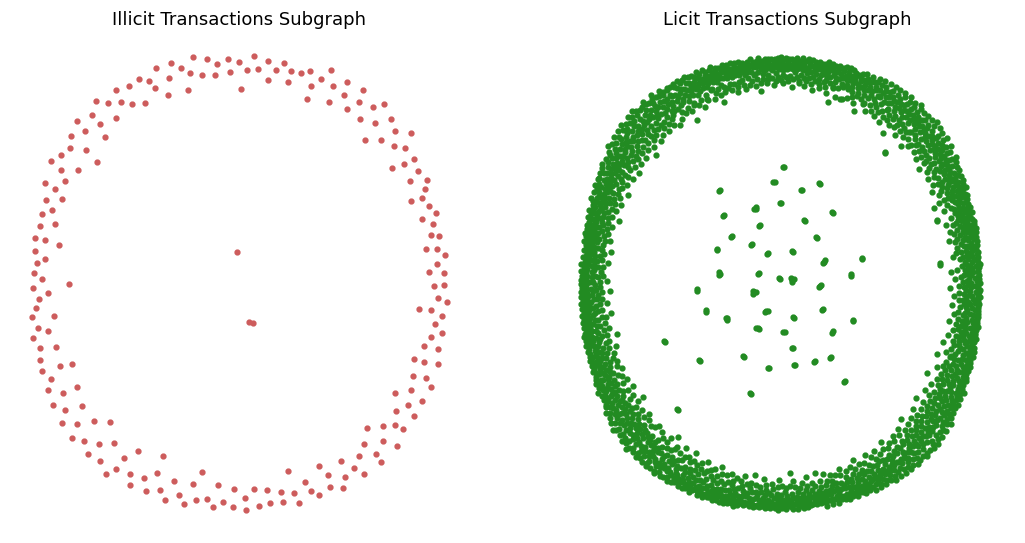

In [60]:
# 提取非法和合法交易的节点，分别绘制子图进行对比
illicit_nodes = classes_sampled[classes_sampled['class_mapped'] == 'illicit']['txId']
licit_nodes = classes_sampled[classes_sampled['class_mapped'] == 'licit']['txId']

# 从主图G中提取对应的子图（只包含这些节点及其之间的连接）
G_illicit = G.subgraph(illicit_nodes)
G_licit = G.subgraph(licit_nodes)

# 并排绘制两个子图
plt.figure(figsize=(12, 6),dpi=108)

# 左侧：非法交易网络（红色）
plt.subplot(1, 2, 1)
nx.draw(G_illicit, with_labels=False, node_size=10, node_color='indianred', edge_color='black')
plt.title('Illicit Transactions Subgraph')

# 右侧：合法交易网络（绿色）
plt.subplot(1, 2, 2)
nx.draw(G_licit, with_labels=False, node_size=10, node_color='forestgreen', edge_color='black')
plt.title('Licit Transactions Subgraph')

plt.show()

# 说明：图看起来是"圈"是因为nx.draw()默认使用spring_layout布局算法
# 这个算法会把节点排列成圆形或类似圆形，这是可视化布局方式，不是数据的真实结构
# 实际要看的是：节点之间的连接关系（黑线）、节点分布是否密集、是否有明显的集群

❌ 不合法交易的 图

节点分布相当稀疏，呈环状分布。

大多数节点位于外围，少数节点集中在中心。

这表明__非法交易的相互联系可能较少__，少数中心节点可能充当网络的枢纽_或关键点。

✅ 合法交易的图

节点密度越高，表明网络越复杂，实体间的交易或互动越多。

可能意味着网络更成熟或更合法。

表明合法交易可能涉及更多相互关联的实体，许多节点关系密切或互动更频繁。

社区检测

非法交易网络发现 16 个社区


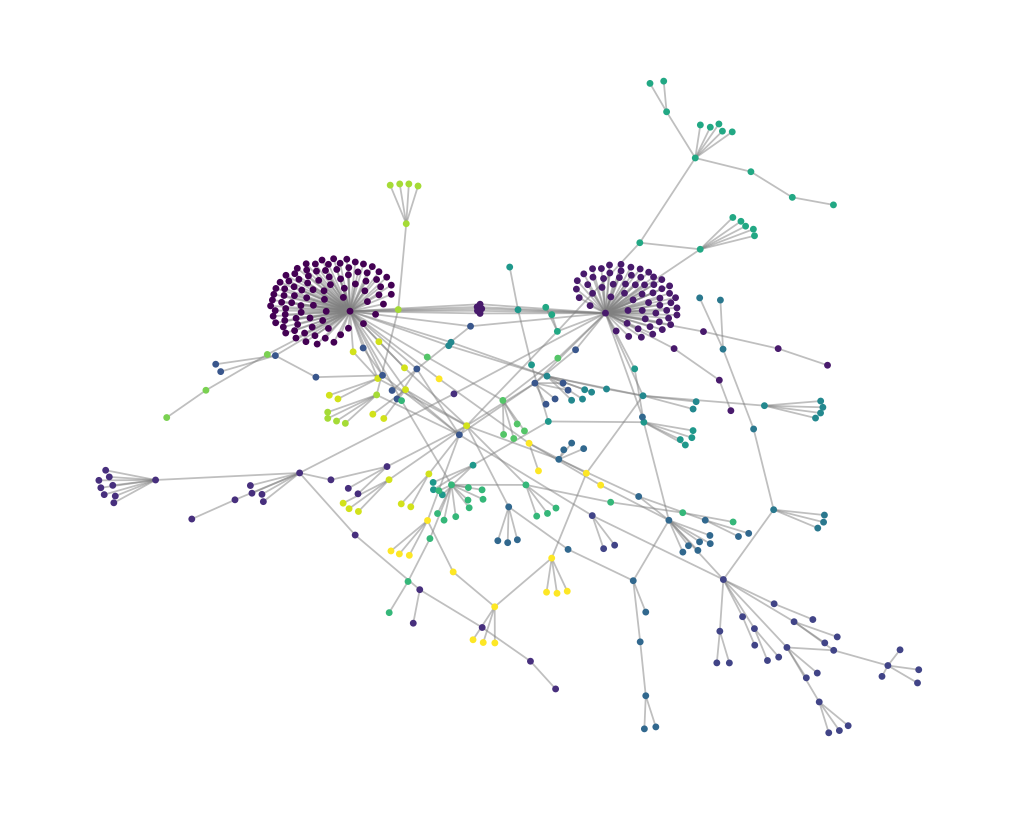

In [72]:
#计算最佳分区 ( 基于鲁文算法)
partition = community_louvain.best_partition(G_giant)
print(f"非法交易网络发现 {len(set(partition.values()))} 个社区")

# 画图
plt.figure(figsize=(10, 8),dpi=128)

pos = nx.spring_layout(G_giant)
cmap = plt.get_cmap('viridis')
nx.draw_networkx_nodes(G_giant, pos, node_color=list(partition.values()), node_size=8, cmap=cmap)
nx.draw_networkx_edges(G_giant, pos, alpha=0.5, edge_color='grey')
plt.axis('off')

plt.show()